## Introduction
The machine learning problem we are trying to solve is predicting the College Football Playoff Commitee's top 25 teams ranking. This matters beacuse th CFP Commitee's rankings are riddled with controversey year after year, as teams are constantly frustrated with their ranking. These rankings matter heavily, as they determine how prestigious of a bowl game teams play in, as well as who gets to compete for a national champsionship. There is very little information on what the commitee considers when they rank the teams, so our model could be used to give teams insight into what particular statistics the committe might value the most when they determine which teams should be ranked higher than others. Teams could then place emphasis on say making sure they have good passing offense or a positive turnover margin if the model shows teams who perform well in those categories are ranked well by the commitee.

The dataset we are using we got from Kaggle at the following link: https://shorturl.at/glT68

It holds data on over a 140 statistical categories(our features) on all FBS teams(the best 130 or so teams in the country) for every year the College Playoff Committe has existed, which is from 2014 to the present. Examples of features in our dataset are total points scored, offensive yards per play, sacks, and many more. We have over 800 records in our dataset.



## Data Cleaning

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import sklearn

In [28]:
first_year = 14 # the first dataset is from 2014
num_years = 9 # the datasets go from 2014-2022
df_dict = {} # holds individual dataframes for each year

Load every dataset into a dataframe and maps the year to its corresponding dataframe.

In [29]:
for year in range(first_year, first_year + num_years - 2):
    df = pd.read_csv("cfb" + str(year) + ".csv")
    df_dict[year] = df

Adds the year the datasets are from as a column in each dataframe. We will drop the year feature eventually, but it will be helpful when we feature engineer later after merging the dataframes into one big dataframe.

In [30]:
for year in range(first_year, first_year + num_years - 2):
    df = df_dict[year]
    df['year'] = year

Merges each individual dataframe into one big dataframe.

In [31]:
key_set = sorted(list(df_dict.keys()))
while len(key_set) > 1:
  df0 = df_dict[key_set[0]]
  df1 = df_dict[key_set[1]]
  shared_columns = df0.columns.intersection(df1.columns)
  df0 = df0.loc[:, shared_columns]
  df1 = df1.loc[:, shared_columns]
  df0 = pd.concat([df0, df1], ignore_index=True)
  df_dict[key_set[0]] = df0
  key_set.remove(key_set[1])
df = df_dict[14] # our one big dataframe after merging

There are two University of Miami's in our datasets. One in Florida and another in Ohio. We wanted to strip the parentheses off the location to help for a later step which also deals with parsing info out of parentheses.

In [32]:
df['Team'] = df['Team'].str.replace('Miami \(FL\)', 'Miami FL', regex=True)
df['Team'] = df['Team'].str.replace('Miami \(OH\)', 'Miami OH', regex=True)

## Feature Engineering

The conference a team is plays a big role in how the commitee ranks them. Most of the games teams play are against teams in the same conference, and some conferences have historically had higher performing teams. As a result, teams in these more elite conferences often have harder schedules, and thus it is critical to take into consideration the conference a team plays in when ranking them.

In our datasets, the conference is not its own feature, it is attached to the feature for the team's name. Hence, we parse the conference from the team's name and add a column for the conference the team is in.

In [33]:
df['conference'] = df['Team'].apply(lambda x: x[x.find('(') + 1: x.find(')')] if '(' in x and ')' in x else x)

After we parse the conference from the team name feature and create the conference feature, we can remove the conference from the team name.

In [34]:
df['Team'] = df['Team'].apply(lambda x: x[:x.find('(')] if '(' in x else x)
df['Team'] = df['Team'].str[:-1]

There were a couple individual records with missing/wrong conferences, so we manually set the teams' conference to its correct one.

In [35]:
df.loc[df['conference'] == 'Independent', 'conference'] = 'FBS Independent'
df.loc[(df['conference'] == '') & (df['Team'] == 'Ole Miss'), 'conference'] = 'SEC'
df.loc[(df['conference'] == '') & (df['Team'] == 'Pittsburgh'), 'conference'] = 'ACC'

Our class label is if the team was ranked in the top 25 or not for the given year, so we utilize the lists below to add a column which holds a 1 if the team was ranked in the top 25 that year and a 0 if not.

In [36]:
# lists of the CFP Commitee's top 25 ranking each year

top25_14 = ['Alabama', 'Oregon', 'Florida St.', 'Ohio St.', 'Baylor',
            'TCU', 'Mississippi St.', 'Michigan St.', 'Ole Miss', 'Arizona',
            'Kansas St.', 'Georgia Tech', 'Georgia', 'UCLA', 'Arizona St.',
            'Missouri', 'Clemson', 'Wisconsin', 'Auburn', 'Boise St.',
            'Louisville', 'Utah', 'LSU', 'Southern California', 'Minnesota'] # top 25 from 2014

top25_15 = ['Clemson', 'Alabama', 'Michigan St.', 'Oklahoma', 'Iowa',
            'Stanford', 'Ohio St.', 'Notre Dame', 'Florida St.', 'North Carolina',
            'TCU', 'Ole Miss', 'Northwestern', 'Michigan', 'Oregon',
            'Oklahoma St.', 'Baylor', 'Houston', 'Florida', 'LSU',
            'Navy', 'Utah', 'Tennessee', 'Temple', 'Southern California'] # top 25 from 2015

top25_16 = ['Alabama', 'Clemson', 'Ohio St.', 'Washington', 'Penn St.',
            'Michigan', 'Oklahoma', 'Wisconsin', 'Southern California', 'Colorado',
            'Florida St.', 'Oklahoma St.', 'Louisville', 'Auburn', 'Western Mich.',
            'West Virginia', 'Florida', 'Stanford', 'Utah', 'LSU',
            'Tennessee', 'Virginia Tech', 'Pittsburgh', 'Temple', 'Navy'] # top 25 from 2016

top25_17 = ['Clemson', 'Oklahoma', 'Georgia', 'Alabama', 'Ohio St.',
            'Wisconsin', 'Auburn', 'Southern California', 'Penn St.', 'Miami FL',
            'Washington', 'UCF', 'Stanford', 'Notre Dame', 'TCU',
            'Michigan St.', 'LSU', 'Washington St.', 'Oklahoma St.', 'Memphis',
            'Northwestern', 'Virginia Tech', 'Mississippi St.', 'NC State', 'Boise St.'] # top 25 from 2017

top25_18 = ['Alabama', 'Clemson', 'Notre Dame', 'Oklahoma', 'Georgia',
            'Ohio St.', 'Michigan', 'UCF', 'Washington', 'Florida',
            'LSU', 'Penn St.', 'Washington St.', 'Kentucky', 'Texas',
            'West Virginia', 'Utah', 'Mississippi St.', 'Texas A&M', 'Syracuse',
            'Fresno St.', 'Northwestern', 'Missouri', 'Iowa St.', 'Boise St.'] # top 25 from 2018

top25_19 = ['LSU', 'Ohio St.', 'Clemson', 'Oklahoma', 'Georgia',
            'Oregon', 'Baylor', 'Wisconsin', 'Florida', 'Penn St.',
            'Utah', 'Auburn', 'Alabama', 'Michigan', 'Notre Dame',
            'Iowa', 'Memphis', 'Minnesota', 'Boise St.', 'Appalachian St.',
            'Cincinnati', 'Southern California', 'Navy', 'Virginia', 'Oklahoma St.'] # top 25 from 2019

top25_20 = ['Alabama', 'Clemson', 'Ohio St.', 'Notre Dame', 'Texas A&M',
            'Oklahoma', 'Florida', 'Cincinnati', 'Georgia', 'Iowa St.',
            'Indiana', 'Coastal Carolina', 'North Carolina', 'Northwestern', 'Iowa',
            'BYU', 'Southern California', 'Miami FL', 'Louisiana', 'Texas',
            'Oklahoma St.', 'San Jose St.', 'NC State', 'Tulsa', 'Oregon'] # top 25 from 2020

top25_21 = ['Alabama', 'Michigan', 'Georgia', 'Cincinnati', 'Notre Dame',
            'Ohio St.', 'Baylor', 'Ole Miss', 'Oklahoma St.', 'Michigan St.',
            'Utah', 'Pittsburgh', 'BYU', 'Oregon', 'Iowa',
            'Oklahoma', 'Wake Forest', 'NC State', 'Clemson', 'Houston',
            'Arkansas', 'Kentucky', 'Louisiana', 'San Diego St.', 'Texas A&M'] # top 25 from 2021

top25_22 = ['Georgia', 'Michigan', 'TCU', 'Ohio St.', 'Alabama',
            'Tennessee', 'Clemson', 'Utah', 'Kansas St.', 'Southern California',
            'Penn St.', 'Washington', 'Florida St.', 'Oregon St.', 'Oregon',
            'Tulane', 'LSU', 'UCLA', 'South Carolina', 'Texas',
            'Notre Dame', 'Mississippi St.', 'NC State', 'Troy', 'UTSA'] # top 25 from 2022

top25_dict = {14: top25_14, 15: top25_15, 16: top25_16, 17: top25_17, 18: top25_18,
              19: top25_19, 20: top25_20, 21: top25_21, 22: top25_22} # dictionary to be able to grab rankings for a desired year

df['top 25'] = df.apply(lambda row: 1 if row['Team'] in top25_dict.get(row['year'], []) else 0, axis=1)

After we create the feature that says if a team was in the top 25 or not for the given year, we can drop the year column.

In [37]:
df = df.drop('year', axis=1)

In [38]:
df

,Team,Games,Win,Loss,Off.Rank,Off.Plays,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,...,Fumbles.Recovered,Opponents.Intercepted,Turnovers.Gain,Fumbles.Lost,Interceptions.Thrown.y,Turnovers.Lost,Turnover.Margin,Avg.Turnover.Margin.per.Game,conference,top 25
0,Akron,12,5,7,88,891,4479,5.03,32,373.3,...,11,13,24,12,14,26,-2,-0.17,MAC,0
1,Alabama,14,12,2,17,1018,6783,6.66,67,484.5,...,9,11,20,12,10,22,-2,-0.14,SEC,1
2,Arizona,14,10,4,25,1139,6491,5.70,55,463.6,...,13,13,26,8,10,18,8,0.57,Pac-12,1
3,Arizona St.,13,10,3,34,975,5750,5.90,54,442.3,...,13,14,27,4,9,13,14,1.08,Pac-12,1
4,Arkansas,13,7,6,60,916,5278,5.76,52,406.0,...,12,12,24,11,6,17,7,0.54,SEC,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,West Virginia,9,5,4,42,690,3804,5.51,28,422.7,...,2,10,12,6,3,9,3,0.33,Big 12,0
855,Western Ky.,11,5,6,120,699,3200,4.58,21,290.9,...,4,5,9,10,2,12,-3,-0.27,C-USA,0
856,Western Mich.,6,4,2,15,392,2878,7.34,32,479.7,...,1,2,3,4,2,6,-3,-0.50,MAC,0
857,Wisconsin,6,3,3,93,431,2153,5.00,17,358.8,...,4,4,8,5,6,11,-3,-0.50,Big Ten,0


In [39]:
df['Win-Ratio'] = df['Win'] / df['Games']
df.columns.values

array(['Team', 'Games', 'Win', 'Loss', 'Off.Rank', 'Off.Plays',
       'Off.Yards', 'Off.Yards.Play', 'Off.TDs', 'Off.Yards.per.Game',
       'Def.Rank', 'Def.Plays', 'Yards.Allowed', 'Yards.Play.Allowed',
       'Off.TDs.Allowed', 'Total.TDs.Allowed', 'Yards.Per.Game.Allowed',
       'First.Down.Rank', 'First.Down.Runs', 'First.Down.Passes',
       'First.Down.Penalties', 'First.Downs', 'First.Down.Def.Rank',
       'Opp.First.Down.Runs', 'Opp.First.Down.Passes',
       'Opp.First.Down.Penalties', 'Opp.First.Downs', 'X4th.Down.Rank',
       'X4th.Attempts', 'X4th.Conversions', 'X4th.Percent',
       'X4rd.Down.Def.Rank', 'Opp.4th.Conversion', 'Opp.4th.Attempt',
       'Opponent.4th.Percent', 'Kickoff.Return.Rank', 'Kickoffs.Returned',
       'Kickoff.Return.Yards', 'Kickoff.Return.Touchdowns',
       'Avg.Yard.per.Kickoff.Return', 'Passing.Off.Rank', 'Pass.Attempts',
       'Pass.Completions', 'Interceptions.Thrown.x', 'Pass.Yards',
       'Pass.Yards.Attempt', 'Yards.Completion', 'Pa

## Data Exploration

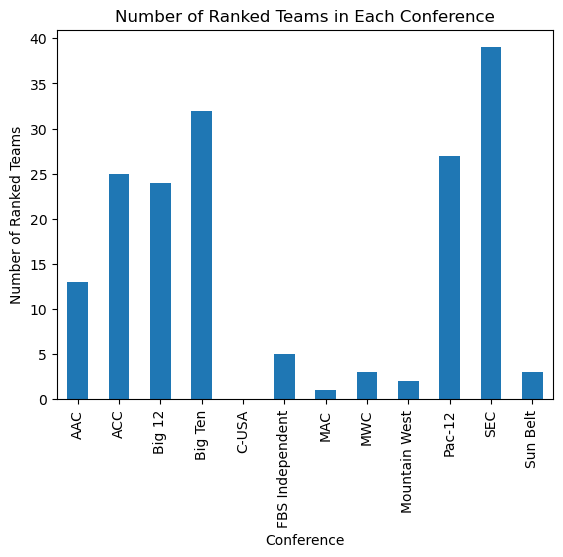

In [40]:
conference_ranked_counts = df.groupby('conference')['top 25'].sum()
conference_ranked_counts.plot(kind='bar')
plt.xlabel('Conference')
plt.ylabel('Number of Ranked Teams')
plt.title('Number of Ranked Teams in Each Conference')
plt.show()

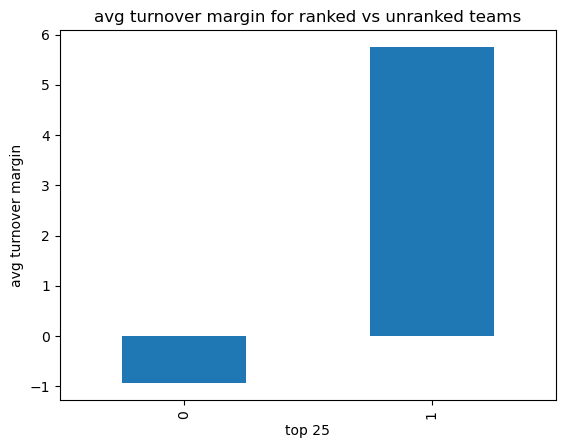

In [41]:
conference_ranked_counts = df.groupby('top 25')['Turnover.Margin'].mean()
conference_ranked_counts.plot(kind='bar')
plt.xlabel('top 25')
plt.ylabel('avg turnover margin')
plt.title('avg turnover margin for ranked vs unranked teams')
plt.show()

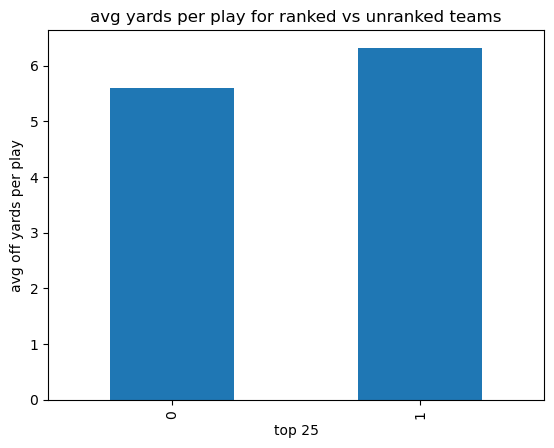

In [42]:
conference_ranked_counts = df.groupby('top 25')['Off.Yards.Play'].mean()
conference_ranked_counts.plot(kind='bar')
plt.xlabel('top 25')
plt.ylabel('avg off yards per play')
plt.title('avg yards per play for ranked vs unranked teams')
plt.show()

## Modeling

In [43]:
one_hot = pd.get_dummies(df['conference'])
one_hot = one_hot.astype('int')
#df = pd.get_dummies(df, columns = ['conference'])
df = df.drop('conference', axis = 1)
df.join(one_hot)

,Team,Games,Win,Loss,Off.Rank,Off.Plays,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,...,Big 12,Big Ten,C-USA,FBS Independent,MAC,MWC,Mountain West,Pac-12,SEC,Sun Belt
0,Akron,12,5,7,88,891,4479,5.03,32,373.3,...,0,0,0,0,1,0,0,0,0,0
1,Alabama,14,12,2,17,1018,6783,6.66,67,484.5,...,0,0,0,0,0,0,0,0,1,0
2,Arizona,14,10,4,25,1139,6491,5.70,55,463.6,...,0,0,0,0,0,0,0,1,0,0
3,Arizona St.,13,10,3,34,975,5750,5.90,54,442.3,...,0,0,0,0,0,0,0,1,0,0
4,Arkansas,13,7,6,60,916,5278,5.76,52,406.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,West Virginia,9,5,4,42,690,3804,5.51,28,422.7,...,1,0,0,0,0,0,0,0,0,0
855,Western Ky.,11,5,6,120,699,3200,4.58,21,290.9,...,0,0,1,0,0,0,0,0,0,0
856,Western Mich.,6,4,2,15,392,2878,7.34,32,479.7,...,0,0,0,0,1,0,0,0,0,0
857,Wisconsin,6,3,3,93,431,2153,5.00,17,358.8,...,0,1,0,0,0,0,0,0,0,0


In [44]:
no_string_df = df.drop(['Team'], axis=1)

def convert_time(str_time):
    minutes, seconds = str_time.split(':')
    return (int(minutes) * 60) + int(seconds)

no_string_df['Time.of.Possession'] = no_string_df['Time.of.Possession'].apply(lambda x: convert_time(x))
no_string_df['Average.Time.of.Possession.per.Game'] = no_string_df['Average.Time.of.Possession.per.Game'].apply(lambda x: convert_time(x))

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
pca = PCA()
scaled_df = scaler.fit_transform(no_string_df)
scaled_df = pd.DataFrame(scaled_df, columns=no_string_df.columns)
scaled_df

,Games,Win,Loss,Off.Rank,Off.Plays,Off.Yards,Off.Yards.Play,Off.TDs,Off.Yards.per.Game,Def.Rank,...,Fumbles.Recovered,Opponents.Intercepted,Turnovers.Gain,Fumbles.Lost,Interceptions.Thrown.y,Turnovers.Lost,Turnover.Margin,Avg.Turnover.Margin.per.Game,top 25,Win-Ratio
0,-0.050466,-0.446310,0.508252,0.637047,0.235443,-0.385058,-0.972226,-0.696697,-0.518039,-0.548021,...,0.857357,0.517239,0.842495,1.159168,0.902483,1.335620,-0.324687,-0.305429,-0.503999,-0.454191
1,0.994114,1.788214,-1.444290,-1.271152,1.068188,1.542599,1.242032,1.671711,1.228926,-1.413022,...,0.243888,0.072931,0.184732,1.159168,-0.068683,0.627521,-0.324687,-0.257377,1.984132,1.517728
2,0.994114,1.149778,-0.663273,-1.056144,1.861591,1.298295,-0.062071,0.859685,0.900585,1.046825,...,1.470826,0.517239,1.171376,-0.052177,-0.068683,-0.080578,1.016207,0.879852,1.984132,0.878187
3,0.471824,1.149778,-1.053781,-0.814259,0.786235,0.678333,0.209617,0.792016,0.565959,0.452137,...,1.470826,0.739393,1.335817,-1.263522,-0.311474,-0.965702,1.820743,1.696735,1.984132,1.124164
4,0.471824,0.192125,0.117743,-0.115482,0.399369,0.283431,0.019436,0.656679,-0.004318,-1.467084,...,1.164091,0.295085,0.842495,0.856332,-1.039848,-0.257603,0.882117,0.831800,-0.503999,0.091059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,-1.617335,-0.446310,-0.663273,-0.599251,-1.082523,-0.949801,-0.320174,-0.967372,0.258041,-1.602241,...,-1.903254,-0.149223,-1.130792,-0.657849,-1.768222,-1.673801,0.345760,0.495436,-0.503999,0.167586
855,-0.572756,-0.446310,0.117743,1.497080,-1.023510,-1.455141,-1.583524,-1.441054,-1.812552,-1.169740,...,-1.289785,-1.259994,-1.624114,0.553496,-2.011013,-1.142727,-0.458776,-0.465602,-0.503999,-0.284615
856,-3.184205,-0.765528,-1.444290,-1.324904,-3.036523,-1.724545,2.165771,-0.696697,1.153517,-0.115520,...,-2.209988,-1.926456,-2.610758,-1.263522,-2.011013,-2.204875,-0.458776,-0.834000,-0.503999,0.665007
857,-3.184205,-1.084746,-1.053781,0.771427,-2.780799,-2.331121,-1.012979,-1.711729,-0.745835,-1.710366,...,-1.289785,-1.482148,-1.788555,-0.960686,-1.039848,-1.319751,-0.458776,-0.834000,-0.503999,-0.081125


In [ ]:

# features we are using for the prediction
#test_df = df.drop(['Team','top 25', 'year'],axis=1)

# data we are trying to predict
#result = df['top 25']

## Results

In [82]:
features = no_string_df.drop('top 25', axis=1)
labels = no_string_df['top 25'].values.ravel()
scaled_features = scaled_df.drop('top 25', axis=1)
scaled_labels = scaled_df['top 25'].values.ravel()

Decision Trees with different parameters

In [88]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()
param_grid = {'max_depth': [5, 10, 15, 20], 'min_samples_leaf': [5, 10, 15, 20], 'max_features': [5, 10, 15]}
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
nested_scores = cross_val_score(grid_search, features, labels, cv=5)
print("Average accuracy:", nested_scores.mean() * 100, "%")

Average accuracy: 86.03019175846593 %


Naive Bayes

In [89]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
scores = cross_val_score(gnb, features, labels, cv=10, scoring='accuracy')
print("Average accuracy:", scores.mean() * 100, "%")

Average accuracy: 81.37619699042406 %


KNN

In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

param_grid = {'pca__n_components': list(range(5, 19)), 'knn__n_neighbors': list(range(1, 25))}

gr_sch = GridSearchCV(pl, param_grid, cv = 5)
gr_sch.fit(features, labels)
outer_loop = KFold(n_splits = 5, shuffle = True, random_state = 21)
nested_scores = cross_val_score(gr_sch, features, labels, cv = outer_loop)
accuracy = nested_scores.mean()
print("Nested CV accuracy:", accuracy * 100, "%")

Nested CV accuracy: 84.16768665850671 %


SVM

In [98]:
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

svm_pl = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
prm_grd = { 'svc__C': [0.1, 1, 10, 100], 'svc__kernel': ['linear', 'rbf', 'poly']}
gr_sch = GridSearchCV(svm_pl, prm_grd, cv = 5)
predictions = cross_val_predict(gr_sch, features, labels, cv = outer_loop)
accuracy = cross_val_score(gr_sch, features, labels, cv = 5, scoring = 'accuracy').mean()
print("Accuracy:", accuracy * 100, "%")

Accuracy: 88.35577315381478 %


Neural Nets

In [99]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

@ignore_warnings(category=ConvergenceWarning)
def run_nn():
    pl = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(max_iter = 1000, random_state = 21))])
    prm_grd = {'mlp__hidden_layer_sizes': [(30,), (40,), (50,), (60,)], 'mlp__activation': ['logistic', 'tanh', 'relu']}
    grid_search = GridSearchCV(pl, prm_grd, cv=5)
    accuracy = cross_val_score(grid_search, features, labels, cv = 5, scoring = 'accuracy').mean()
    print("Accuracy:", accuracy * 100, "%")
  

run_nn()

Accuracy: 87.07534339725281 %


Random Forest Ensemble

In [100]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

gnb = GaussianNB()
predicted_labels = cross_val_predict(gnb, features, labels, cv=10)
rf_clf = RandomForestClassifier(random_state = 21)
prm_grd = {'n_estimators': [50, 100, 150]}
grd_sch = GridSearchCV(rf_clf, prm_grd, cv = 5)
predictions = cross_val_predict(grd_sch, features, labels, cv = 5)
cls_rpt = classification_report(labels, predicted_labels)
print(cls_rpt)

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       685
           1       0.53      0.84      0.65       174

    accuracy                           0.81       859
   macro avg       0.74      0.82      0.76       859
weighted avg       0.87      0.81      0.83       859

